In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%env OMP_NUM_THREADS=6

env: OMP_NUM_THREADS=6


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt


nside = 256
mask = nmt.mask_apodization(hp.read_map("/home/zequnl/src/NaMaster/test/mask.fits", verbose=False),
                            5., apotype="Smooth")

# Let's now create a fictitious theoretical power spectrum to generate
# Gaussian realizations:
larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.
clarr[0:2] = 0.0
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr


# This routine generates a spin-0 and a spin-2 Gaussian random field based
# on these power spectra
def get_sample_field():
    mp_t, mp_q, mp_u = hp.synfast([cl_tt, cl_ee, cl_bb, cl_te],
                                  nside, verbose=False)
    return nmt.NmtField(mask, [mp_t]), nmt.NmtField(mask, [mp_q, mp_u])


# We also copy this function from sample_workspaces.py. It computes
# power spectra given a pair of fields and a workspace.
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled

In [3]:
# Let's generate one particular sample and its power spectrum.
f0, f2 = get_sample_field()
# We will use 1 multipole per bandpower.
BIN_MIN = 2
ells = np.arange(3 * nside, dtype='int32')  # Array of multipoles
b = nmt.NmtBin(nside=nside, bpws=ells, ells=ells + BIN_MIN, weights=np.ones_like(ells))
# b = nmt.NmtBin.from_nside_linear(nside, 1)

w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2, f2, b)
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f2, f2, f2, f2)

coupled_covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22, coupled=True).reshape([3*nside, 4,
                                                            3*nside, 4])
coupled_covar_EE_EE = coupled_covar_22_22[:, 0, :, 0]

In [4]:

n_ell = len(b.get_effective_ells())
covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22).reshape([n_ell, 4,
                                                            n_ell, 4])
covar_EE_EE = covar_22_22[:, 0, :, 0]

In [5]:
mcm = w22.get_coupling_matrix().reshape([3*nside, 4, 3*nside, 4])[:, 0, :, 0]

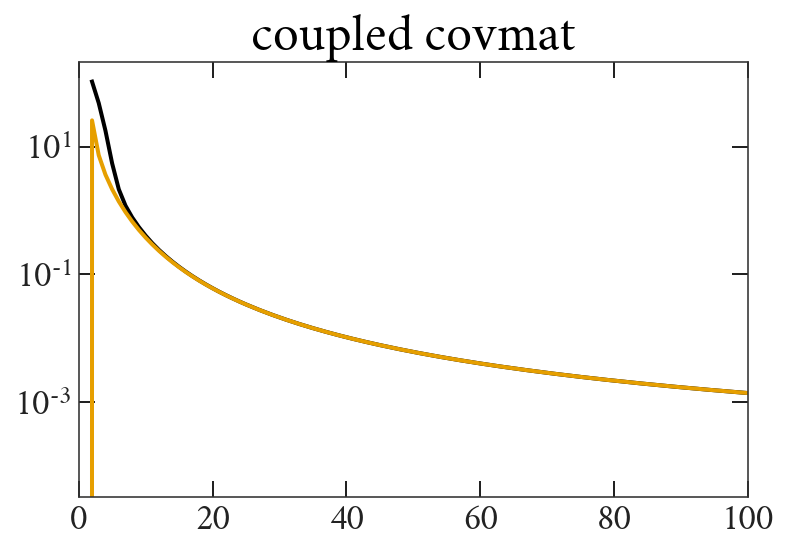

In [6]:
recovered_coupled = mcm[2:,2:] @ covar_EE_EE @ np.transpose(mcm[2:,2:])
plt.title("coupled covmat")

plt.plot(np.arange(2,3*nside), np.diag(recovered_coupled), "-")
plt.plot(np.diag(coupled_covar_EE_EE),"-")
plt.xlim(0,100)
# plt.ylim(1e2,2e3)
plt.yscale("log")

(0.0, 3.0)

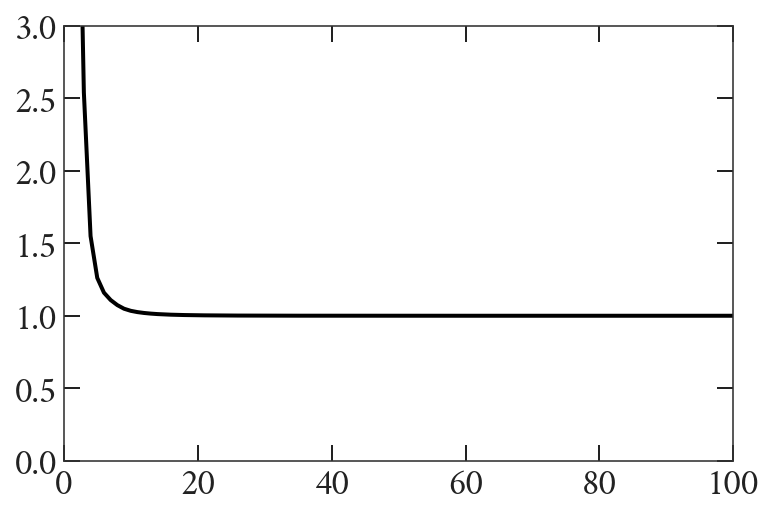

In [7]:
plt.plot(
    np.diag(recovered_coupled) /
    np.diag(coupled_covar_EE_EE)[2:],"-")
plt.xlim(0,100)
plt.ylim(0.0, 3.0)